# Trickng ResNet18 Image Classifier Using LLM Suggested Image Perturbations

In [1]:
# download imagenette dataset
# imagenette is subset of 10 classes from full ImageNet dataset
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

--2025-05-15 04:47:45--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.128.104, 54.231.133.184, 54.231.198.112, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.128.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1557161267 (1.5G) [application/x-tar]
Saving to: ‘imagenette2.tgz.1’

imagenette2.tgz.1   100%[===================>]   1.45G  15.2MB/s    in 2m 3s   

2025-05-15 04:49:49 (12.1 MB/s) - ‘imagenette2.tgz.1’ saved [1557161267/1557161267]



In [2]:
# Unpack dataset in current Colab environment
!tar -xvzf imagenette2.tgz

Streaming output truncated to the last 5000 lines.
imagenette2/train/n03888257/n03888257_16077.JPEG
imagenette2/train/n03888257/n03888257_23339.JPEG
imagenette2/train/n03888257/n03888257_44204.JPEG
imagenette2/train/n03888257/n03888257_61633.JPEG
imagenette2/train/n03888257/n03888257_15067.JPEG
imagenette2/train/n03888257/n03888257_75365.JPEG
imagenette2/train/n03888257/n03888257_63966.JPEG
imagenette2/train/n03888257/n03888257_3927.JPEG
imagenette2/train/n03888257/n03888257_20684.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00047778.JPEG
imagenette2/train/n03888257/n03888257_14016.JPEG
imagenette2/train/n03888257/n03888257_37776.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00041706.JPEG
imagenette2/train/n03888257/n03888257_17513.JPEG
imagenette2/train/n03888257/n03888257_17143.JPEG
imagenette2/train/n03888257/n03888257_6738.JPEG
imagenette2/train/n03888257/n03888257_4355.JPEG
imagenette2/train/n03888257/ILSVRC2012_val_00030583.JPEG
imagenette2/train/n03888257/n03888257_18127.JP

In [3]:
# Check GPU
!nvidia-smi --query-gpu=name --format=csv,noheader

NVIDIA A100-SXM4-40GB


In [4]:
# pip install missing packages from main implementation
!pip install -U bitsandbytes
!pip install -q transformers accelerate bitsandbytes torch
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ur0qegd9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ur0qegd9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [5]:
import re
import urllib
from google.colab import userdata
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import json
import numpy as np
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
import clip


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
# Test images
# url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)
# img = Image.open(filename)

In [8]:
# Authenticate with token
# Retrieves token: Assumes that everyone needs their own hugging face account and add token to colab env
hf_token = userdata.get('HF_TOKEN')

# Load model with authentication
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
llm_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    token=hf_token,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16
    ),
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
#Test that the model and image loading worked
def generate_response(prompt, max_new_tokens=50):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = llm_model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


PROMPTING

In [10]:
# perturbations_prompt = "Give locations, size, and type of perturbations to be done to an image. The image size is 1920 by 1080 and the maximum perturbation size is 100 by 100. Give a list of 10 perturbations which specify pixel location, size of the perturbation patch, channel an integer between 0 and 3, and type of perturbation. Respond only in JSON format with no explainations."

# perturbation_examples = """  {"location": [20, 30], "size": [10, 10], "channel": 0, "type": "gaussian_noise"},
#   {"location": [50, 60], "size": [8, 8], "channel": 0, "type": "blur"},
#   {"location": [70, 20], "size": [6, 6], "channel": 1, "type": "occlusion"},
#   {"location": [10, 10], "size": [9, 9], "channel": 2, "type": "brightness_increase"},
#   {"location": [80, 40], "size": [7, 7], "channel": 0, "type": "contrast_decrease"},
#   {"location": [30, 70], "size": [10, 10], "channel": 1, "type": "salt_and_pepper_noise"},
#   {"location": [60, 15], "size": [5, 5], "channel": 2, "type": "motion_blur"},
#   {"location": [25, 85], "size": [6, 6], "channel": 1, "type": "color_shift"},
#   {"location": [90, 90], "size": [10, 10], "channel": 2, "type": "sharpen"},
#   {"location": [40, 50], "size": [7, 7], "channel": 0, "type": "grayscale"}
#   """

# ranks = [0.9,1,0.2,0.3,0.1,0.5,0,0.2,0.2,0.8]



In [11]:
perturbations_prompt = "Give types of perturbations to be done to an image. The image size is 256 by 256.\
Give a list of up to 10 perturbations where operations are one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
Rotate requires an angle parameter.\
adjust_brightness requires a factor parameter.\
blur_patch requires center, radius, and sigma parameters.\
add_stripe_noise requires orientation, stripe_width, intensity, and location.\
add_patch requires location, size, and type parameters with an option color parameter.\
translate requires x_shift and y_shift parameters.\
Respond only in JSON format with no explainations."

perturbation_examples = """
    [{
            "operation": "rotate",
            "angle": 15
    },
    {
            "operation": "adjust_brightness",
            "factor": 1.5
    },
    {
            "operation": "blur_patch",
            "center": [80, 60],
            "radius": 20,
            "sigma": 5.0
    },
    {
            "operation": "add_stripe_noise",
            "orientation": "horizontal",
            "stripe_width": 10,
            "intensity": 0.1,
            "location": 0.3
    },
    {
            "operation": "add_patch",
            "location": [50, 50],
            "size": [40, 40],
            "type": "noise"
    },
    {
            "operation": "add_patch",
            "location": [120, 120],
            "size": [30, 30],
            "type": "color",
            "color": [255, 0, 0]
    },
    {
            "operation": "translate",
            "x_shift": 20,
            "y_shift": 30
    }]"""

In [12]:
# original prompt is below:
# f"Give types of perturbations to be done to an image. The image size is {size[0]} by {size[1]}.\
# Give a list of up to 10 perturbations where operations are one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
# Rotate requires an angle parameter.\
# adjust_brightness requires a factor parameter.\
# blur_patch requires center, radius, and sigma parameters.\
# add_stripe_noise requires orientation, stripe_width, intensity, and location.\
# add_patch requires location, size, and type parameters with an option color parameter.\
# translate requires x_shift and y_shift parameters.\
# Respond only in JSON format with no explainations."

In [13]:
def generate_new_perturbations_prompt(prev_pert = perturbation_examples, ranks = [], size = [224,224], label  = "", labels = []):
  init_prompt = f"Give a list of up to 10 image perturbations that can trick ResNet's image classifier into misclassifying the perturbed image while keeping the perturbed image as close to the original one as possible. The image is of a " + label + ". Strictly follow these guidelines:"
  base_prompt = f"\
Operations are exclusively one of these: [rotate, adjust_brightness, blur_patch, add_stripe_noise, add_patch, translate].\
The image size is {size[0]} by {size[1]}.\
Rotate requires an angle parameter.\
adjust_brightness requires a factor parameter.\
blur_patch requires center, radius, and sigma parameters.\
add_stripe_noise requires orientation, stripe_width, intensity, and location.\
add_patch requires location, size, and type parameters with an option color parameter.\
translate requires x_shift and y_shift parameters.\
Strictly respond only in JSON format with no explanations."

  perturbations_prompt = f"{init_prompt}{base_prompt}"
  if ranks == []:
    prompt = init_prompt + "\Examples: " + str(prev_pert) + "Generate new perturbations strictly based on these rules:" + base_prompt
  else:
    prompt = "Previous perturbations were: " + str(prev_pert) + " and had a score of: " + str(ranks) + " on the following actual labels " + str(labels) + ".\nStricly follow these rules to give a list of up to 10 perturbations to increase that loss value:\n" + base_prompt
  return prompt

In [14]:
# test = generate_new_perturbations_prompt()
# print(test)

In [15]:
## Select only the json list from the response
def extract_text_between_brackets(text):
  text = text.split("Strictly respond only in JSON format with no explanations.")[1] # Ignore example json list
  text = text.replace(' ', '')
  text = text.replace('\n', '')
  text = text.replace('\\','')
  if len(re.findall(r"\[\{(.*?)\}\]", text, re.DOTALL)) == 0: # If no full JSON exists return empty list
    return "[]"
  return "[{"+re.findall(r"\[\{(.*?)\}\]", text, re.DOTALL)[0]+"}]"

In [16]:
# response = generate_response(test, 400)
# print(extract_text_between_brackets(response))
# commands = json.loads(extract_text_between_brackets(response))

PERTURBATOR

In [17]:
def rotate_image(image, angle):
    return image.rotate(angle)

def adjust_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def blur_patch(image, center, radius, sigma):
    img_np = np.array(image)
    (h, w, _) = img_np.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    cv2.circle(mask, tuple(center), radius, 255, -1)

    blurred = cv2.GaussianBlur(img_np, (0, 0), sigma)

    mask = mask[:, :, np.newaxis] / 255.0
    output = img_np * (1 - mask) + blurred * mask
    output = np.clip(output, 0, 255).astype(np.uint8)

    return Image.fromarray(output)

def add_stripe_noise(image, orientation, stripe_width, intensity, location=0):
    img_np = np.array(image).astype(np.float32) / 255.0
    noise = np.random.uniform(-intensity, intensity, img_np.shape)

    mask = np.zeros_like(img_np)
    H, W, _ = img_np.shape

    if orientation == "horizontal":
        # Horizontal stripe centered at given y-location
        y_center = int(location * H)
        y_start = max(0, y_center - stripe_width // 2)
        y_end = min(H, y_center + stripe_width // 2)
        mask[y_start:y_end, :, :] = 1
    elif orientation == "vertical":
        # Vertical stripe centered at given x-location
        x_center = int(location * W)
        x_start = max(0, x_center - stripe_width // 2)
        x_end = min(W, x_center + stripe_width // 2)
        mask[:, x_start:x_end, :] = 1

    noisy_img = np.clip(img_np + noise * mask, 0, 1)
    noisy_img = (noisy_img * 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

def add_patch(image, location, size, type_="noise", color=None):
    img_np = np.array(image)

    patch = None
    if type_ == "noise":
        patch = np.random.randint(0, 256, (size[1], size[0], 3), dtype=np.uint8)
    elif type_ == "color" and color is not None:
        patch = np.ones((size[1], size[0], 3), dtype=np.uint8) * np.array(color, dtype=np.uint8)

    x, y = location  # Now input is exact (x, y)

    # Boundary check
    H, W, _ = img_np.shape
    x = max(0, min(x, W - size[0]))
    y = max(0, min(y, H - size[1]))

    img_np[y:y+size[1], x:x+size[0]] = patch

    return Image.fromarray(img_np)

def translate_image(image, x_shift, y_shift):
    img_np = np.array(image)
    (h, w) = img_np.shape[:2]

    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    shifted = cv2.warpAffine(img_np, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    return Image.fromarray(shifted)


In [18]:
def apply_action(image, action_dict):
    operation = action_dict["operation"]

    if operation == "rotate":
        return rotate_image(image, angle=action_dict["angle"])
    elif operation == "adjust_brightness":
        return adjust_brightness(image, factor=action_dict["factor"])
    elif operation == "blur_patch":
        return blur_patch(
            image,
            center=action_dict["center"],
            radius=action_dict["radius"],
            sigma=action_dict["sigma"]
        )
    elif operation == "add_stripe_noise":
        return add_stripe_noise(
            image,
            orientation=action_dict["orientation"],
            stripe_width=action_dict["stripe_width"],
            intensity=action_dict["intensity"],
            location=action_dict.get("location", 0)
        )
    elif operation == "add_patch":
        return add_patch(
            image,
            location=action_dict["location"],
            size=action_dict["size"],
            type_=action_dict.get("type", "noise"),
            color=action_dict.get("color")
        )
    elif operation == "translate":
        return translate_image(
            image,
            x_shift=action_dict["x_shift"],
            y_shift=action_dict["y_shift"]
        )
    else:
        raise ValueError(f"Unknown operation: {operation}")


In [19]:
def show_image(image, title="Image"):
    plt.imshow(np.array(image))
    plt.title(title)
    plt.axis('off')
    plt.show()

# for command in commands:
#   perturbed_img = apply_action(img, command)
#   show_image(perturbed_img, title=f"Perturbation: {command['operation']}")

RESNET

In [20]:
# resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# # or any of these variants
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# # resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# resnet_model.eval()

In [21]:
# Download ImageNet labels
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [22]:
def classify_image(image, model, data):
  # model should be preloaded fine-tuned model from earlier
  # data is the current subset of the ImageNette val dataset
  # image is the current image from the test set
  # sample execution (requires torchvision)
  # this could def be implemented a lot nicer
  input_image = image

  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(224),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]),
  ])
  # Normalize input image
  input_tensor = preprocess(input_image)

  # create a mini-batch as expected by the model
  input_batch = input_tensor.unsqueeze(0)
  input_batch = input_batch.to(device)
  print(device)

  # Make prediction on label
  with torch.no_grad():
      output = model(input_batch)
  # Tensor of shape 10, with confidence scores over CIFAR10's 10 classes
  # print(output[0])
  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  # print(probabilities)

  # Read the categories
  categories = data.dataset.classes

  # Show top category per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  # for i in range(top5_prob.size(0)):
  #     print(categories[top5_catid[i]], top5_prob[i].item())

  # Return top prediction
  return categories[top5_catid[0]], top5_prob[0].item(), probabilities

In [23]:
# img, label = test[14]
# c, s, probabilities = classify_image(img, model=model, data=test)
# c

CLIP SIMILARITY

In [24]:
# # Initialize clip comparison objects
# clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [25]:
def image_distance(image1, image2, clip_model, clip_preprocess):
  clip_model.to(device)
  cos = torch.nn.CosineSimilarity(dim=0)

  image1_preprocess = clip_preprocess(image1).unsqueeze(0).to(device)
  image1_features = clip_model.encode_image( image1_preprocess)

  image2_preprocess = clip_preprocess(image2).unsqueeze(0).to(device)
  image2_features = clip_model.encode_image( image2_preprocess)

  similarity = cos(image1_features[0],image2_features[0]).item()
  return 1 - (similarity+1)/2


def image_distance2(image1, image2):
  if image1.shape != image2.shape:
      raise ValueError("Images must have the same shape")
  return np.linalg.norm(image1.astype(float) - image2.astype(float))


In [26]:
# similarity_score = image_distance(img, perturbed_img, clip_model, clip_preprocess)
# similarity_score

LOSS

In [27]:
def loss_func(label, probabilities, similarity):
  c = torch.tensor([0.5], device=device) # Hyperparameter
  loss = torch.nn.CrossEntropyLoss()
  loss = loss(label, probabilities)
  return loss - similarity * c

In [28]:
# one_hot_encoding_of_label = torch.zeros(10, device=device)
# one_hot_encoding_of_label[probabilities.argmax()] = 1
# loss_func(one_hot_encoding_of_label, probabilities, similarity_score)

SUDO CODE FOR POSSIBLE EXECUTION CYCLE?

In [29]:
# Preprocessing to get images that resnet classifies correctly

# prompt = generate_new_perturbations_prompt() ##First Pass
# for epochs
#   for image, label in images: Should probably be in batch form...
#     response = generate_response(prompt, 400) ##First Pass
#     json_list = extract_text_between_brackets(response) ##Done
#     new_image = perturbator(image, json_list) ##Done
#     _, _, probabilities = classify_image(new_image, model=model, data=test) ##Done
#     similarity_score = image_distance(image, new_image, clip_model, clip_preprocess) ##Done
#     loss = loss_func(label, probabilities, similarity_score) ##Done
#     prompt = generate_new_perturbations_prompt(json_list, loss) ##First Pass

# Trick Pre-trained ResNet18 Image Classifier

---



In [30]:
!ls

data	     imagenette2.tgz	resnet18_ImageNette.pth
imagenette2  imagenette2.tgz.1	sample_data


In [31]:
# Load flowers dataset and ResNet model
# Normalize current dataset to specifics of original ImageNet dataset to stabilize and speed up learning
# Reseize images to match previous implementation
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224,224)),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                      std=[0.229, 0.224, 0.225])
# ])

# Load dataset
# Only need test since we are running inferences
# test = datasets.CIFAR10(root='./data', train=False, download=True)
test = datasets.Imagenette(root='./data', split='val', download=True)

# Load ResNet model
# For scalability, we will only use the 18-layer version as its the smallest
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# Replace the final fully connected layer to output 10 classes
model.fc = torch.nn.Linear(model.fc.in_features, 10)

# Map model to GPU
model = model.to(device)

# Initialize clip comparison objects
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
# Load flowers dataset and ResNet model
# Normalize current dataset to specifics of original ImageNet dataset to stabilize and speed up learning
# Reseize images to match previous implementation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

# Load dataset
# Only need test since we are running inferences
# Apply the transform directly to the dataset
# Load val to get baseline accuracy score from model
test_full = datasets.Imagenette(root='./data', split='val', download=True)
val  = datasets.Imagenette(root='./data', split='val', download=True, transform=transform)

# take subset of test datset
test = torch.utils.data.Subset(test_full,
                               np.random.choice(len(test_full), 50,
                                                replace=False))

# Load ResNet model
# For scalability, we will only use the 18-layer version as its the smallest
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# Replace the final fully connected layer to output 10 classes
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Load pretrained checkpoint
model.load_state_dict(torch.load("./resnet18_ImageNette.pth"))

# Map model to GPU
model = model.to(device)

# Initialize clip comparison objects
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Make test loader from here
# The DataLoader will now receive tensors from the transformed dataset
val_loader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [33]:
# Get baseline form running validation set through ResNet18
correct, total = 0, 0
model.eval()
with torch.no_grad():
    # Iterate using the val_loader to get batched data
    for images, labels in val_loader:
        # Move the batch to the device
        images = images.to(device)
        labels = labels.to(device) # Also move labels if you plan to use them later

        # The val_loader already provides 4D tensors (batch_size, channels, height, width)
        pred = model(images)
        _, predicted = pred.max(1)
        total += labels.size(0) # Use labels.size(0) to get the batch size
        correct += (predicted == labels).sum().item()

baseline_accuracy = 100 * (correct / total)
print(f"Baseline Accuracy: {baseline_accuracy}%")

Baseline Accuracy: 97.98726114649682%


In [34]:
valid_operations = ['rotate', 'adjust_brightness', 'blur_patch',
                    'add_stripe_noise', 'add_patch', 'translate']
epochs = 3
# Set size to 224 to match dataset transformation and ResNet expectations
# pass size as list to match prompt implementation

# Set model to evaluation mode for inferences
model.eval()

# Make counter variables for accuracy calculation later
correct = 0
current_img = 0

misclassified_images = []
misclassified_true_images = []
perturbations = []
cur_loss = []
true_labels  = []


import matplotlib.pyplot as plt

for image_idx, (image, label) in enumerate(test):

  true_label = str(test.dataset.classes[label]).lower()
  cur_PIL = image

  for i in range(epochs):
    if i == 0 and image_idx == 0:
      prompt = generate_new_perturbations_prompt(size=  cur_PIL.size)
    else:
      prompt = generate_new_perturbations_prompt(perturbations[-9:], cur_loss[-9:], perturbed_img.size, true_label, true_labels[-9:])
    print(f"STARTING EPOCH {i} FOR IMAGE #{image_idx}")

    response = generate_response(prompt, 400)
    try:
      json_list = json.loads(extract_text_between_brackets(response))
    except json.JSONDecodeError:
      json_list = []

    loss = float(0)
    perturbed_img = cur_PIL

    if json_list != "[]":
      remove_indices = []
      print("Applying perturbations...")
      perturbation_count = 0
      for command in json_list:
        print(f"apply perturbation #{perturbation_count} for image #{image_idx}")
        if 'operation' in command.keys() and command['operation'] in valid_operations:
          try:
            perturbed_img = apply_action(perturbed_img, command)
            perturbation_count += 1
          except:
            print(f"Error in operation: {command['operation']}")
            print(command)
            remove_indices.append(json_list.index(command))
        else:
          print(f"Illegal operation or format: {command}")
          remove_indices.append(json_list.index(command))

      # Show original and perturbed image

      c, s, probabilities = classify_image(perturbed_img, model=model, data=test)
      c = str(c).lower()

      print(c)
      print(true_label)

      if c.strip() == true_label.strip():
        print(f'Correctly classified perturbed image {image_idx}')
        correct += 1
      else:
        print(f'Classified perturbed image {image_idx} wrong')
        misclassified_images.append(perturbed_img)
        misclassified_true_images.append(cur_PIL)


      similarity_score = image_distance(cur_PIL, perturbed_img, clip_model, clip_preprocess)

      one_hot_encoding_of_label = torch.zeros(10, device=device)
      one_hot_encoding_of_label[probabilities.argmax()] = 1
      loss = loss_func(one_hot_encoding_of_label, probabilities, similarity_score)

      json_list = [json_list[i] for i in range(len(json_list)) if i not in remove_indices]
      print(f"Current Loss: {loss}")
      cur_loss.append(loss)
      true_labels.append(true_label)
      perturbations.append(json.dumps(json_list))





  current_img += 1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


STARTING EPOCH 0 FOR IMAGE #0
Applying perturbations...
apply perturbation #0 for image #0
apply perturbation #1 for image #0
apply perturbation #2 for image #0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Error in operation: blur_patch
{'operation': 'blur_patch', 'center': [250, 187.5], 'radius': 25, 'sigma': 4.5}
apply perturbation #2 for image #0
apply perturbation #3 for image #0
Error in operation: add_patch
{'operation': 'add_patch', 'location': [125, 93.75], 'size': [30, 30], 'type': 'noise'}
apply perturbation #3 for image #0
Error in operation: add_patch
{'operation': 'add_patch', 'location': [275, 218.75], 'size': [20, 20], 'type': 'color', 'color': [0, 255, 0]}
apply perturbation #3 for image #0
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 0
Current Loss: tensor([1.4402], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #0
apply perturbation #1 for image #0
apply perturbation #2 for image #0
apply perturbation #3 for image #0
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 0
Current Loss: tensor([1.4352], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #0


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #0
apply perturbation #1 for image #0
apply perturbation #2 for image #0
apply perturbation #3 for image #0
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 0
Current Loss: tensor([1.4347], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #1
apply perturbation #1 for image #1
apply perturbation #2 for image #1
apply perturbation #3 for image #1
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 1
Current Loss: tensor([1.4479], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #1
apply perturbation #1 for image #1
apply perturbation #2 for image #1
apply perturbation #3 for image #1
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 1
Current Loss: tensor([1.4308], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #1


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 1
Current Loss: tensor([1.4611], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #2
apply perturbation #1 for image #2
apply perturbation #2 for image #2
apply perturbation #3 for image #2
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 2
Current Loss: tensor([1.4401], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #2
apply perturbation #1 for image #2
apply perturbation #2 for image #2
apply perturbation #3 for image #2
apply perturbation #4 for image #2
Error in operation: blur_patch
{'operation': 'blur_patch', 'center': 250, 'radius': 50, 'sigma': 5}
apply perturbation #4 for image #2
Error in operation: add_patch
{'operation': 'add_patch', 'location': 0.2, 'size': 50, 'type': 'circle', 'color': 'red'}
apply perturbation #4 for image #2
apply perturbation #5 for image #2
apply perturbation #6 for image #2
apply perturbation #7 for image #2
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 2
Current Loss: tensor([1.4424], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #2


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #2
apply perturbation #1 for image #2
apply perturbation #2 for image #2
apply perturbation #3 for image #2
apply perturbation #4 for image #2
apply perturbation #5 for image #2
Error in operation: add_patch
{'operation': 'add_patch', 'location': 0.2, 'size': 50, 'type': 'circle', 'color': 'red'}
apply perturbation #5 for image #2
Error in operation: blur_patch
{'operation': 'blur_patch', 'center': 0.4, 'radius': 30, 'sigma': 10}
apply perturbation #5 for image #2
apply perturbation #6 for image #2
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 2
Current Loss: tensor([1.4467], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #3
apply perturbation #1 for image #3
apply perturbation #2 for image #3
apply perturbation #3 for image #3
apply perturbation #4 for image #3
apply perturbation #5 for image #3
Error in operation: add_patch
{'operation': 'add_patch', 'location': [200, 200], 'size': 50, 'type': 'circle'}
apply perturbation #5 for image #3
apply perturbation #6 for image #3
apply perturbation #7 for image #3
apply perturbation #8 for image #3
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 3 wrong
Current Loss: tensor([1.5735], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #3
apply perturbation #1 for image #3
apply perturbation #2 for image #3
apply perturbation #3 for image #3
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 3
Current Loss: tensor([1.4539], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #3


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #3
apply perturbation #1 for image #3
apply perturbation #2 for image #3
apply perturbation #3 for image #3
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 3
Current Loss: tensor([1.4177], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #4
apply perturbation #1 for image #4
apply perturbation #2 for image #4
apply perturbation #3 for image #4
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 4
Current Loss: tensor([1.4005], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #4
apply perturbation #1 for image #4
apply perturbation #2 for image #4
apply perturbation #3 for image #4
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 4
Current Loss: tensor([1.4936], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #4


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #4
apply perturbation #1 for image #4
apply perturbation #2 for image #4
apply perturbation #3 for image #4
cuda
('parachute', 'chute')
('chain saw', 'chainsaw')
Classified perturbed image 4 wrong
Current Loss: tensor([1.8829], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #5
apply perturbation #1 for image #5
apply perturbation #2 for image #5
apply perturbation #3 for image #5
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 5
Current Loss: tensor([1.4148], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 5
Current Loss: tensor([1.4758], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #5
apply perturbation #1 for image #5
apply perturbation #2 for image #5
apply perturbation #3 for image #5
apply perturbation #4 for image #5
apply perturbation #5 for image #5
apply perturbation #6 for image #5
Error in operation: add_patch
{'operation': 'add_patch', 'location': [100, 100], 'size': 50, 'type': 'circle', 'color': 'red'}
apply perturbation #6 for image #5
apply perturbation #7 for image #5
apply perturbation #8 for image #5
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 5 wrong
Current Loss: tensor([1.7643], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #6
apply perturbation #1 for image #6
apply perturbation #2 for image #6
apply perturbation #3 for image #6
apply perturbation #4 for image #6
apply perturbation #5 for image #6
apply perturbation #6 for image #6
Error in operation: add_patch
{'operation': 'add_patch', 'location': [100, 100], 'size': 30, 'type': 'circle', 'color': 'red'}
apply perturbation #6 for image #6
apply perturbation #7 for image #6
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 6
Current Loss: tensor([1.9158], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #6
apply perturbation #1 for image #6
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 6
Current Loss: tensor([1.4679], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #6
apply perturbation #1 for image #6
apply perturbation #2 for image #6
apply perturbation #3 for image #6
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 6
Current Loss: tensor([1.5537], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #7
apply perturbation #1 for image #7
apply perturbation #2 for image #7
apply perturbation #3 for image #7
apply perturbation #4 for image #7
apply perturbation #5 for image #7
Error in operation: add_patch
{'operation': 'add_patch', 'location': [200, 200], 'size': 20, 'type': 'circle', 'color': 'red'}
apply perturbation #5 for image #7
apply perturbation #6 for image #7
apply perturbation #7 for image #7
apply perturbation #8 for image #7
cuda
('chain saw', 'chainsaw')
('golf ball',)
Classified perturbed image 7 wrong
Current Loss: tensor([1.9661], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #7
apply perturbation #1 for image #7
apply perturbation #2 for image #7
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 7
Current Loss: tensor([1.4420], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 7
Current Loss: tensor([1.4679], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #8
apply perturbation #1 for image #8
apply perturbation #2 for image #8
apply perturbation #3 for image #8
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 8
Current Loss: tensor([1.4628], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #8
apply perturbation #1 for image #8
apply perturbation #2 for image #8
apply perturbation #3 for image #8
apply perturbation #4 for image #8
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 8
Current Loss: tensor([1.6553], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #8


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #8
apply perturbation #1 for image #8
apply perturbation #2 for image #8
apply perturbation #3 for image #8
apply perturbation #4 for image #8
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 8
Current Loss: tensor([1.6073], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #9
apply perturbation #1 for image #9
apply perturbation #2 for image #9
apply perturbation #3 for image #9
apply perturbation #4 for image #9
apply perturbation #5 for image #9
apply perturbation #6 for image #9
apply perturbation #7 for image #9
Error in operation: add_patch
{'operation': 'add_patch', 'location': [100, 100], 'size': 20, 'type': 'rectangle', 'color': 'red'}
apply perturbation #7 for image #9
apply perturbation #8 for image #9
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 9
Current Loss: tensor([1.7574], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #9
apply perturbation #1 for image #9
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 9
Current Loss: tensor([1.4380], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #9


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #9
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 9
Current Loss: tensor([1.4642], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #10
apply perturbation #1 for image #10
apply perturbation #2 for image #10
apply perturbation #3 for image #10
apply perturbation #4 for image #10
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 10
Current Loss: tensor([1.8212], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #10
apply perturbation #1 for image #10
apply perturbation #2 for image #10
apply perturbation #3 for image #10
apply perturbation #4 for image #10
apply perturbation #5 for image #10
apply perturbation #6 for image #10
apply perturbation #7 for image #10
apply perturbation #8 for image #10
Error in operation: add_patch
{'operation': 'add_patch', 'location': [150, 150], 'size': 30, 'type': 'circle', 'color': 'red'}
apply perturbation #8 for image #10
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 10
Current Loss: tensor([1.5146], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #10


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #10
apply perturbation #1 for image #10
apply perturbation #2 for image #10
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 10
Current Loss: tensor([1.6175], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #11
Error in operation: rotate
{'operation': 'rotate', 'parameters': {'angle': 45}}
apply perturbation #0 for image #11
Error in operation: adjust_brightness
{'operation': 'adjust_brightness', 'parameters': {'factor': 1.9}}
cuda
('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser')
('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser')
Correctly classified perturbed image 11
Current Loss: tensor([1.6831], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #11
apply perturbation #1 for image #11
apply perturbation #2 for image #11
apply perturbation #3 for image #11
cuda
('church', 'church building')
('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser')
Classified perturbed image 11 wrong
Current Loss: tensor([1.7719], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #11


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser')
('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser')
Correctly classified perturbed image 11
Current Loss: tensor([1.6831], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #12
apply perturbation #1 for image #12
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 12
Current Loss: tensor([1.5834], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 12
Current Loss: tensor([1.4642], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #12


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #12
apply perturbation #1 for image #12
apply perturbation #2 for image #12
apply perturbation #3 for image #12
apply perturbation #4 for image #12
apply perturbation #5 for image #12
Error in operation: add_patch
{'operation': 'add_patch', 'location': [200, 200], 'size': 30, 'type': 'circle', 'color': '#FF0000'}
apply perturbation #5 for image #12
apply perturbation #6 for image #12
apply perturbation #7 for image #12
apply perturbation #8 for image #12
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 12
Current Loss: tensor([1.8213], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #13
apply perturbation #1 for image #13
apply perturbation #2 for image #13
apply perturbation #3 for image #13
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 13
Current Loss: tensor([1.4417], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #13
apply perturbation #1 for image #13
apply perturbation #2 for image #13
apply perturbation #3 for image #13
apply perturbation #4 for image #13
apply perturbation #5 for image #13
apply perturbation #6 for image #13
apply perturbation #7 for image #13
Error in operation: add_patch
{'operation': 'add_patch', 'location': [200, 200], 'size': 40, 'type': 'circle', 'color': 'red'}
apply perturbation #7 for image #13
apply perturbation #8 for image #13
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 13
Current Loss: tensor([1.4184], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #13


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #13
apply perturbation #1 for image #13
apply perturbation #2 for image #13
apply perturbation #3 for image #13
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 13
Current Loss: tensor([1.4441], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #14
apply perturbation #1 for image #14
apply perturbation #2 for image #14
apply perturbation #3 for image #14
apply perturbation #4 for image #14
apply perturbation #5 for image #14
apply perturbation #6 for image #14
apply perturbation #7 for image #14
apply perturbation #8 for image #14
apply perturbation #9 for image #14
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 14 wrong
Current Loss: tensor([1.7358], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #14
apply perturbation #1 for image #14
apply perturbation #2 for image #14
apply perturbation #3 for image #14
apply perturbation #4 for image #14
Error in operation: add_patch
{'operation': 'add_patch', 'location': [20, 20], 'size': 20, 'type': 'circle', 'color': 'red'}
apply perturbation #4 for image #14
apply perturbation #5 for image #14
apply perturbation #6 for image #14
apply perturbation #7 for image #14
apply perturbation #8 for image #14
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 14 wrong
Current Loss: tensor([2.0084], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #14


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 14
Current Loss: tensor([1.5435], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #15
Illegal operation or format: {'operations': [['rotate', 30], 'adjust_brightness', 1.5], 'score': 1.5}
apply perturbation #0 for image #15
Illegal operation or format: {'operations': [['rotate', 20], 'adjust_brightness', 1.4], 'score': 1.4}
apply perturbation #0 for image #15
Illegal operation or format: {'operations': [['rotate', 40], 'adjust_brightness', 1.6], 'score': 1.6}
apply perturbation #0 for image #15
Illegal operation or format: {'operations': [['rotate', 25], 'adjust_brightness', 1.7], 'score': 1.7}
apply perturbation #0 for image #15
Illegal operation or format: {'operations': [['rotate', 35], 'adjust_brightness', 1.3], 'score': 1.3}
apply perturbation #0 for image #15
Illegal operation or format: {'operations': [['rotate', 45], 'adjust_brightness', 1.9], 'score': 1.9}
apply perturbation #0 for image #15
Illegal operation or format: {'operations': [['rotate', 10], 'adjust_brightness', 1.8], 'score': 1.8}
apply pe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 15
Current Loss: tensor([1.4616], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #15


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 15
Current Loss: tensor([1.4616], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #16
Illegal operation or format: {'center': [200, 200], 'radius': 50, 'sigma': 3.0}
apply perturbation #0 for image #16
Illegal operation or format: {'orientation': 'vertical', 'stripe_width': 12, 'intensity': 0.1, 'location': 0.3}
cuda
('french horn', 'horn')
('french horn', 'horn')
Correctly classified perturbed image 16
Current Loss: tensor([1.4629], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #16
apply perturbation #1 for image #16
apply perturbation #2 for image #16
cuda
('french horn', 'horn')
('french horn', 'horn')
Correctly classified perturbed image 16
Current Loss: tensor([1.4466], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #16


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('french horn', 'horn')
('french horn', 'horn')
Correctly classified perturbed image 16
Current Loss: tensor([1.4629], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #17
apply perturbation #1 for image #17
apply perturbation #2 for image #17
apply perturbation #3 for image #17
apply perturbation #4 for image #17
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 17
Current Loss: tensor([2.0902], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #17
apply perturbation #1 for image #17
apply perturbation #2 for image #17
apply perturbation #3 for image #17
apply perturbation #4 for image #17
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 17
Current Loss: tensor([1.4362], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #17


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #17
apply perturbation #1 for image #17
apply perturbation #2 for image #17
apply perturbation #3 for image #17
apply perturbation #4 for image #17
Error in operation: add_patch
{'operation': 'add_patch', 'location': [150, 150], 'size': 50, 'type': 'circle', 'color': 'red'}
apply perturbation #4 for image #17
apply perturbation #5 for image #17
apply perturbation #6 for image #17
apply perturbation #7 for image #17
apply perturbation #8 for image #17
cuda
('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser')
('garbage truck', 'dustcart')
Classified perturbed image 17 wrong
Current Loss: tensor([2.1376], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('cassette player',)
('cassette player',)
Correctly classified perturbed image 18
Current Loss: tensor([1.4628], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('cassette player',)
('cassette player',)
Correctly classified perturbed image 18
Current Loss: tensor([1.4628], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #18


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #18
apply perturbation #1 for image #18
apply perturbation #2 for image #18
cuda
('cassette player',)
('cassette player',)
Correctly classified perturbed image 18
Current Loss: tensor([1.4430], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 19
Current Loss: tensor([1.4758], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 19
Current Loss: tensor([1.4758], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #19


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #19
apply perturbation #1 for image #19
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 19
Current Loss: tensor([1.8590], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #20
apply perturbation #1 for image #20
apply perturbation #2 for image #20
apply perturbation #3 for image #20
apply perturbation #4 for image #20
apply perturbation #5 for image #20
Error in operation: add_patch
{'operation': 'add_patch', 'location': [100, 100], 'size': 30, 'type': 'circle', 'color': 'blue'}
apply perturbation #5 for image #20
apply perturbation #6 for image #20
apply perturbation #7 for image #20
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 20 wrong
Current Loss: tensor([1.4455], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #20
apply perturbation #1 for image #20
apply perturbation #2 for image #20
apply perturbation #3 for image #20
apply perturbation #4 for image #20
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 20 wrong
Current Loss: tensor([1.4414], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #20


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 20
Current Loss: tensor([1.4792], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #21
apply perturbation #1 for image #21
apply perturbation #2 for image #21
apply perturbation #3 for image #21
apply perturbation #4 for image #21
Error in operation: add_patch
{'operation': 'add_patch', 'location': [160, 180], 'size': 40, 'type': 'circle', 'color': 'red'}
apply perturbation #4 for image #21
apply perturbation #5 for image #21
apply perturbation #6 for image #21
apply perturbation #7 for image #21
apply perturbation #8 for image #21
cuda
('chain saw', 'chainsaw')
('tench', 'tinca tinca')
Classified perturbed image 21 wrong
Current Loss: tensor([1.8505], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #21
apply perturbation #1 for image #21
apply perturbation #2 for image #21
cuda
('chain saw', 'chainsaw')
('tench', 'tinca tinca')
Classified perturbed image 21 wrong
Current Loss: tensor([1.8120], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #21


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 21
Current Loss: tensor([1.4621], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 22
Current Loss: tensor([1.4614], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 22
Current Loss: tensor([1.4614], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #22


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #22
apply perturbation #1 for image #22
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 22
Current Loss: tensor([1.5161], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 23
Current Loss: tensor([1.4632], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #23
apply perturbation #1 for image #23
apply perturbation #2 for image #23
apply perturbation #3 for image #23
apply perturbation #4 for image #23
apply perturbation #5 for image #23
apply perturbation #6 for image #23
apply perturbation #7 for image #23
apply perturbation #8 for image #23
apply perturbation #9 for image #23
cuda
('parachute', 'chute')
('tench', 'tinca tinca')
Classified perturbed image 23 wrong
Current Loss: tensor([1.5882], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #23


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #23
apply perturbation #1 for image #23
apply perturbation #2 for image #23
apply perturbation #3 for image #23
apply perturbation #4 for image #23
apply perturbation #5 for image #23
apply perturbation #6 for image #23
apply perturbation #7 for image #23
apply perturbation #8 for image #23
cuda
('parachute', 'chute')
('tench', 'tinca tinca')
Classified perturbed image 23 wrong
Current Loss: tensor([1.6675], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #24
apply perturbation #1 for image #24
apply perturbation #2 for image #24
apply perturbation #3 for image #24
apply perturbation #4 for image #24
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 24
Current Loss: tensor([1.4153], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #24
apply perturbation #1 for image #24
apply perturbation #2 for image #24
apply perturbation #3 for image #24
apply perturbation #4 for image #24
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 24
Current Loss: tensor([1.4112], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #24


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #24
apply perturbation #1 for image #24
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 24
Current Loss: tensor([1.4441], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #25
apply perturbation #1 for image #25
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 25
Current Loss: tensor([1.8206], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #25
apply perturbation #1 for image #25
apply perturbation #2 for image #25
apply perturbation #3 for image #25
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 25
Current Loss: tensor([1.6489], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #25


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #25
apply perturbation #1 for image #25
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 25
Current Loss: tensor([1.4532], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #26
apply perturbation #1 for image #26
apply perturbation #2 for image #26
apply perturbation #3 for image #26
apply perturbation #4 for image #26
apply perturbation #5 for image #26
apply perturbation #6 for image #26
apply perturbation #7 for image #26
apply perturbation #8 for image #26
apply perturbation #9 for image #26
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 26
Current Loss: tensor([1.4759], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #26
apply perturbation #1 for image #26
apply perturbation #2 for image #26
apply perturbation #3 for image #26
apply perturbation #4 for image #26
apply perturbation #5 for image #26
apply perturbation #6 for image #26
apply perturbation #7 for image #26
apply perturbation #8 for image #26
apply perturbation #9 for image #26
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 26
Current Loss: tensor([1.8161], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #26


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 26
Current Loss: tensor([1.4619], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #27
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 27
Current Loss: tensor([1.4333], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #27
apply perturbation #1 for image #27
apply perturbation #2 for image #27
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 27
Current Loss: tensor([1.4319], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #27


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #27
apply perturbation #1 for image #27
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 27
Current Loss: tensor([1.4305], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #28
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 28
Current Loss: tensor([1.5186], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #28
apply perturbation #1 for image #28
apply perturbation #2 for image #28
apply perturbation #3 for image #28
apply perturbation #4 for image #28
cuda
('garbage truck', 'dustcart')
('church', 'church building')
Classified perturbed image 28 wrong
Current Loss: tensor([1.8521], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #28
apply perturbation #1 for image #28
apply perturbation #2 for image #28
apply perturbation #3 for image #28
apply perturbation #4 for image #28
cuda
('garbage truck', 'dustcart')
('church', 'church building')
Classified perturbed image 28 wrong
Current Loss: tensor([1.8633], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #29
apply perturbation #1 for image #29
apply perturbation #2 for image #29
apply perturbation #3 for image #29
apply perturbation #4 for image #29
apply perturbation #5 for image #29
apply perturbation #6 for image #29
apply perturbation #7 for image #29
apply perturbation #8 for image #29
apply perturbation #9 for image #29
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 29
Current Loss: tensor([1.4346], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #29
apply perturbation #1 for image #29
apply perturbation #2 for image #29
apply perturbation #3 for image #29
apply perturbation #4 for image #29
apply perturbation #5 for image #29
apply perturbation #6 for image #29
apply perturbation #7 for image #29
apply perturbation #8 for image #29
apply perturbation #9 for image #29
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 29
Current Loss: tensor([1.4192], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #29


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #29
apply perturbation #1 for image #29
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 29
Current Loss: tensor([1.4508], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #30
apply perturbation #1 for image #30
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 30
Current Loss: tensor([1.4597], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #30
apply perturbation #1 for image #30
apply perturbation #2 for image #30
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 30
Current Loss: tensor([1.4552], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #30
apply perturbation #1 for image #30
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 30
Current Loss: tensor([1.4558], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #31
apply perturbation #1 for image #31
apply perturbation #2 for image #31
apply perturbation #3 for image #31
apply perturbation #4 for image #31
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 31
Current Loss: tensor([1.6133], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 31
Current Loss: tensor([1.4812], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #31


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 31
Current Loss: tensor([1.4812], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #32
apply perturbation #1 for image #32
apply perturbation #2 for image #32
apply perturbation #3 for image #32
apply perturbation #4 for image #32
apply perturbation #5 for image #32
apply perturbation #6 for image #32
apply perturbation #7 for image #32
apply perturbation #8 for image #32
apply perturbation #9 for image #32
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 32
Current Loss: tensor([1.5385], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #32
apply perturbation #1 for image #32
apply perturbation #2 for image #32
apply perturbation #3 for image #32
apply perturbation #4 for image #32
apply perturbation #5 for image #32
apply perturbation #6 for image #32
apply perturbation #7 for image #32
apply perturbation #8 for image #32
apply perturbation #9 for image #32
cuda
('parachute', 'chute')
('chain saw', 'chainsaw')
Classified perturbed image 32 wrong
Current Loss: tensor([1.9011], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #32


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #32
apply perturbation #1 for image #32
apply perturbation #2 for image #32
apply perturbation #3 for image #32
apply perturbation #4 for image #32
apply perturbation #5 for image #32
apply perturbation #6 for image #32
apply perturbation #7 for image #32
apply perturbation #8 for image #32
apply perturbation #9 for image #32
cuda
('parachute', 'chute')
('chain saw', 'chainsaw')
Classified perturbed image 32 wrong
Current Loss: tensor([1.5580], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #33
apply perturbation #1 for image #33
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 33
Current Loss: tensor([1.4405], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #33
apply perturbation #1 for image #33
apply perturbation #2 for image #33
apply perturbation #3 for image #33
apply perturbation #4 for image #33
apply perturbation #5 for image #33
apply perturbation #6 for image #33
apply perturbation #7 for image #33
apply perturbation #8 for image #33
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 33
Current Loss: tensor([1.3771], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #33


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #33
apply perturbation #1 for image #33
apply perturbation #2 for image #33
apply perturbation #3 for image #33
apply perturbation #4 for image #33
cuda
('chain saw', 'chainsaw')
('chain saw', 'chainsaw')
Correctly classified perturbed image 33
Current Loss: tensor([1.4863], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #34
apply perturbation #1 for image #34
apply perturbation #2 for image #34
apply perturbation #3 for image #34
apply perturbation #4 for image #34
apply perturbation #5 for image #34
apply perturbation #6 for image #34
apply perturbation #7 for image #34
apply perturbation #8 for image #34
apply perturbation #9 for image #34
cuda
('church', 'church building')
('tench', 'tinca tinca')
Classified perturbed image 34 wrong
Current Loss: tensor([1.8976], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #34
apply perturbation #1 for image #34
apply perturbation #2 for image #34
apply perturbation #3 for image #34
apply perturbation #4 for image #34
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 34
Current Loss: tensor([1.8394], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #34


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #34
apply perturbation #1 for image #34
apply perturbation #2 for image #34
apply perturbation #3 for image #34
apply perturbation #4 for image #34
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 34
Current Loss: tensor([1.6585], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #35
apply perturbation #1 for image #35
apply perturbation #2 for image #35
apply perturbation #3 for image #35
apply perturbation #4 for image #35
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 35
Current Loss: tensor([1.4248], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #35
apply perturbation #1 for image #35
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 35
Current Loss: tensor([1.4430], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #35


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #35
apply perturbation #1 for image #35
apply perturbation #2 for image #35
apply perturbation #3 for image #35
apply perturbation #4 for image #35
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 35
Current Loss: tensor([1.6762], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #36
apply perturbation #1 for image #36
apply perturbation #2 for image #36
apply perturbation #3 for image #36
apply perturbation #4 for image #36
apply perturbation #5 for image #36
apply perturbation #6 for image #36
apply perturbation #7 for image #36
apply perturbation #8 for image #36
apply perturbation #9 for image #36
cuda
('parachute', 'chute')
('tench', 'tinca tinca')
Classified perturbed image 36 wrong
Current Loss: tensor([1.7270], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #36
apply perturbation #1 for image #36
apply perturbation #2 for image #36
apply perturbation #3 for image #36
apply perturbation #4 for image #36
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 36
Current Loss: tensor([1.4245], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #36


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #36
apply perturbation #1 for image #36
apply perturbation #2 for image #36
apply perturbation #3 for image #36
apply perturbation #4 for image #36
apply perturbation #5 for image #36
apply perturbation #6 for image #36
apply perturbation #7 for image #36
apply perturbation #8 for image #36
apply perturbation #9 for image #36
cuda
('parachute', 'chute')
('tench', 'tinca tinca')
Classified perturbed image 36 wrong
Current Loss: tensor([1.8398], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #37
apply perturbation #1 for image #37
apply perturbation #2 for image #37
apply perturbation #3 for image #37
apply perturbation #4 for image #37
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 37
Current Loss: tensor([1.3645], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #37
apply perturbation #1 for image #37
apply perturbation #2 for image #37
apply perturbation #3 for image #37
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 37
Current Loss: tensor([1.4234], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #37


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #37
apply perturbation #1 for image #37
apply perturbation #2 for image #37
apply perturbation #3 for image #37
apply perturbation #4 for image #37
apply perturbation #5 for image #37
apply perturbation #6 for image #37
apply perturbation #7 for image #37
apply perturbation #8 for image #37
apply perturbation #9 for image #37
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 37 wrong
Current Loss: tensor([1.8001], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #38
apply perturbation #1 for image #38
apply perturbation #2 for image #38
apply perturbation #3 for image #38
apply perturbation #4 for image #38
cuda
('french horn', 'horn')
('french horn', 'horn')
Correctly classified perturbed image 38
Current Loss: tensor([1.4086], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #38
apply perturbation #1 for image #38
apply perturbation #2 for image #38
apply perturbation #3 for image #38
apply perturbation #4 for image #38
cuda
('french horn', 'horn')
('french horn', 'horn')
Correctly classified perturbed image 38
Current Loss: tensor([1.4169], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #38


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #38
apply perturbation #1 for image #38
apply perturbation #2 for image #38
apply perturbation #3 for image #38
apply perturbation #4 for image #38
apply perturbation #5 for image #38
apply perturbation #6 for image #38
apply perturbation #7 for image #38
apply perturbation #8 for image #38
apply perturbation #9 for image #38
cuda
('church', 'church building')
('french horn', 'horn')
Classified perturbed image 38 wrong
Current Loss: tensor([1.4636], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #39
apply perturbation #1 for image #39
apply perturbation #2 for image #39
apply perturbation #3 for image #39
apply perturbation #4 for image #39
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 39
Current Loss: tensor([1.4508], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #39
apply perturbation #1 for image #39
apply perturbation #2 for image #39
apply perturbation #3 for image #39
apply perturbation #4 for image #39
apply perturbation #5 for image #39
apply perturbation #6 for image #39
apply perturbation #7 for image #39
apply perturbation #8 for image #39
apply perturbation #9 for image #39
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 39
Current Loss: tensor([1.4343], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #39


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 39
Current Loss: tensor([1.4659], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #40
apply perturbation #1 for image #40
apply perturbation #2 for image #40
apply perturbation #3 for image #40
apply perturbation #4 for image #40
apply perturbation #5 for image #40
apply perturbation #6 for image #40
apply perturbation #7 for image #40
apply perturbation #8 for image #40
apply perturbation #9 for image #40
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 40
Current Loss: tensor([1.8187], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #40
apply perturbation #1 for image #40
apply perturbation #2 for image #40
apply perturbation #3 for image #40
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 40
Current Loss: tensor([1.4513], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #40


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #40
apply perturbation #1 for image #40
apply perturbation #2 for image #40
apply perturbation #3 for image #40
apply perturbation #4 for image #40
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 40
Current Loss: tensor([1.4628], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #41
apply perturbation #1 for image #41
apply perturbation #2 for image #41
apply perturbation #3 for image #41
apply perturbation #4 for image #41
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 41
Current Loss: tensor([1.9352], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #41
apply perturbation #1 for image #41
apply perturbation #2 for image #41
apply perturbation #3 for image #41
apply perturbation #4 for image #41
cuda
('garbage truck', 'dustcart')
('english springer', 'english springer spaniel')
Classified perturbed image 41 wrong
Current Loss: tensor([2.0842], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #41


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 41
Current Loss: tensor([1.4683], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #42
apply perturbation #1 for image #42
apply perturbation #2 for image #42
apply perturbation #3 for image #42
apply perturbation #4 for image #42
apply perturbation #5 for image #42
apply perturbation #6 for image #42
apply perturbation #7 for image #42
apply perturbation #8 for image #42
apply perturbation #9 for image #42
cuda
('parachute', 'chute')
('cassette player',)
Classified perturbed image 42 wrong
Current Loss: tensor([1.5465], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #42
apply perturbation #1 for image #42
cuda
('cassette player',)
('cassette player',)
Correctly classified perturbed image 42
Current Loss: tensor([1.4347], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #42


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #42
apply perturbation #1 for image #42
apply perturbation #2 for image #42
apply perturbation #3 for image #42
apply perturbation #4 for image #42
cuda
('church', 'church building')
('cassette player',)
Classified perturbed image 42 wrong
Current Loss: tensor([1.5943], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #43
apply perturbation #1 for image #43
apply perturbation #2 for image #43
apply perturbation #3 for image #43
apply perturbation #4 for image #43
apply perturbation #5 for image #43
apply perturbation #6 for image #43
apply perturbation #7 for image #43
apply perturbation #8 for image #43
apply perturbation #9 for image #43
cuda
('parachute', 'chute')
('english springer', 'english springer spaniel')
Classified perturbed image 43 wrong
Current Loss: tensor([1.8254], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #43
apply perturbation #1 for image #43
apply perturbation #2 for image #43
apply perturbation #3 for image #43
apply perturbation #4 for image #43
apply perturbation #5 for image #43
apply perturbation #6 for image #43
apply perturbation #7 for image #43
apply perturbation #8 for image #43
apply perturbation #9 for image #43
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 43
Current Loss: tensor([1.7498], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #43


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #43
apply perturbation #1 for image #43
apply perturbation #2 for image #43
apply perturbation #3 for image #43
apply perturbation #4 for image #43
cuda
('english springer', 'english springer spaniel')
('english springer', 'english springer spaniel')
Correctly classified perturbed image 43
Current Loss: tensor([1.4398], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 44
Current Loss: tensor([1.4628], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #44
apply perturbation #1 for image #44
apply perturbation #2 for image #44
apply perturbation #3 for image #44
apply perturbation #4 for image #44
apply perturbation #5 for image #44
apply perturbation #6 for image #44
apply perturbation #7 for image #44
apply perturbation #8 for image #44
apply perturbation #9 for image #44
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 44
Current Loss: tensor([1.7906], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #44


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('church', 'church building')
('church', 'church building')
Correctly classified perturbed image 44
Current Loss: tensor([1.4628], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #45
apply perturbation #1 for image #45
apply perturbation #2 for image #45
apply perturbation #3 for image #45
apply perturbation #4 for image #45
apply perturbation #5 for image #45
apply perturbation #6 for image #45
apply perturbation #7 for image #45
apply perturbation #8 for image #45
Error in operation: add_patch
{'operation': 'add_patch', 'location': [200, 200], 'size': 40, 'type': 'circle', 'color': 'red'}
apply perturbation #8 for image #45
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 45
Current Loss: tensor([1.7423], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #45
apply perturbation #1 for image #45
apply perturbation #2 for image #45
apply perturbation #3 for image #45
apply perturbation #4 for image #45
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 45
Current Loss: tensor([1.4067], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #45


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #45
apply perturbation #1 for image #45
apply perturbation #2 for image #45
apply perturbation #3 for image #45
apply perturbation #4 for image #45
cuda
('tench', 'tinca tinca')
('tench', 'tinca tinca')
Correctly classified perturbed image 45
Current Loss: tensor([1.4369], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #46
apply perturbation #1 for image #46
apply perturbation #2 for image #46
apply perturbation #3 for image #46
apply perturbation #4 for image #46
apply perturbation #5 for image #46
apply perturbation #6 for image #46
apply perturbation #7 for image #46
apply perturbation #8 for image #46
apply perturbation #9 for image #46
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 46 wrong
Current Loss: tensor([2.0918], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #46
apply perturbation #1 for image #46
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 46 wrong
Current Loss: tensor([1.9007], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #46


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #46
apply perturbation #1 for image #46
apply perturbation #2 for image #46
apply perturbation #3 for image #46
apply perturbation #4 for image #46
apply perturbation #5 for image #46
apply perturbation #6 for image #46
apply perturbation #7 for image #46
apply perturbation #8 for image #46
apply perturbation #9 for image #46
cuda
('parachute', 'chute')
('golf ball',)
Classified perturbed image 46 wrong
Current Loss: tensor([1.7766], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #47
apply perturbation #1 for image #47
apply perturbation #2 for image #47
apply perturbation #3 for image #47
apply perturbation #4 for image #47
cuda
('church', 'church building')
('garbage truck', 'dustcart')
Classified perturbed image 47 wrong
Current Loss: tensor([1.8777], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #47
apply perturbation #1 for image #47
cuda
('garbage truck', 'dustcart')
('garbage truck', 'dustcart')
Correctly classified perturbed image 47
Current Loss: tensor([1.4456], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #47


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #47
apply perturbation #1 for image #47
apply perturbation #2 for image #47
apply perturbation #3 for image #47
apply perturbation #4 for image #47
apply perturbation #5 for image #47
apply perturbation #6 for image #47
apply perturbation #7 for image #47
apply perturbation #8 for image #47
apply perturbation #9 for image #47
cuda
('parachute', 'chute')
('garbage truck', 'dustcart')
Classified perturbed image 47 wrong
Current Loss: tensor([1.6239], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #48
apply perturbation #1 for image #48
apply perturbation #2 for image #48
apply perturbation #3 for image #48
apply perturbation #4 for image #48
apply perturbation #5 for image #48
apply perturbation #6 for image #48
apply perturbation #7 for image #48
apply perturbation #8 for image #48
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 48
Current Loss: tensor([1.3764], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 48
Current Loss: tensor([1.4619], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #48


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #48
apply perturbation #1 for image #48
cuda
('parachute', 'chute')
('parachute', 'chute')
Correctly classified perturbed image 48
Current Loss: tensor([1.4414], device='cuda:0')
STARTING EPOCH 0 FOR IMAGE #49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #49
apply perturbation #1 for image #49
apply perturbation #2 for image #49
apply perturbation #3 for image #49
apply perturbation #4 for image #49
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 49
Current Loss: tensor([1.9395], device='cuda:0')
STARTING EPOCH 1 FOR IMAGE #49


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Applying perturbations...
apply perturbation #0 for image #49
apply perturbation #1 for image #49
cuda
('golf ball',)
('golf ball',)
Correctly classified perturbed image 49
Current Loss: tensor([1.4371], device='cuda:0')
STARTING EPOCH 2 FOR IMAGE #49
Applying perturbations...
apply perturbation #0 for image #49
apply perturbation #1 for image #49
apply perturbation #2 for image #49
apply perturbation #3 for image #49
apply perturbation #4 for image #49
apply perturbation #5 for image #49
apply perturbation #6 for image #49
apply perturbation #7 for image #49
apply perturbation #8 for image #49
cuda
('church', 'church building')
('golf ball',)
Classified perturbed image 49 wrong
Current Loss: tensor([1.8116], device='cuda:0')


In [35]:
# Check final accuracy of inferences
print(f"Baseline Accuracy (from fine-tuning): {baseline_accuracy}%")
print(f"Final Accuracy: {(100 * (correct/(len(test)*3)))}%")

Baseline Accuracy (from fine-tuning): 97.98726114649682%
Final Accuracy: 78.0%


In [36]:
cur_loss

[tensor([1.4402], device='cuda:0'),
 tensor([1.4352], device='cuda:0'),
 tensor([1.4347], device='cuda:0'),
 tensor([1.4479], device='cuda:0'),
 tensor([1.4308], device='cuda:0'),
 tensor([1.4611], device='cuda:0'),
 tensor([1.4401], device='cuda:0'),
 tensor([1.4424], device='cuda:0'),
 tensor([1.4467], device='cuda:0'),
 tensor([1.5735], device='cuda:0'),
 tensor([1.4539], device='cuda:0'),
 tensor([1.4177], device='cuda:0'),
 tensor([1.4005], device='cuda:0'),
 tensor([1.4936], device='cuda:0'),
 tensor([1.8829], device='cuda:0'),
 tensor([1.4148], device='cuda:0'),
 tensor([1.4758], device='cuda:0'),
 tensor([1.7643], device='cuda:0'),
 tensor([1.9158], device='cuda:0'),
 tensor([1.4679], device='cuda:0'),
 tensor([1.5537], device='cuda:0'),
 tensor([1.9661], device='cuda:0'),
 tensor([1.4420], device='cuda:0'),
 tensor([1.4679], device='cuda:0'),
 tensor([1.4628], device='cuda:0'),
 tensor([1.6553], device='cuda:0'),
 tensor([1.6073], device='cuda:0'),
 tensor([1.7574], device='cu

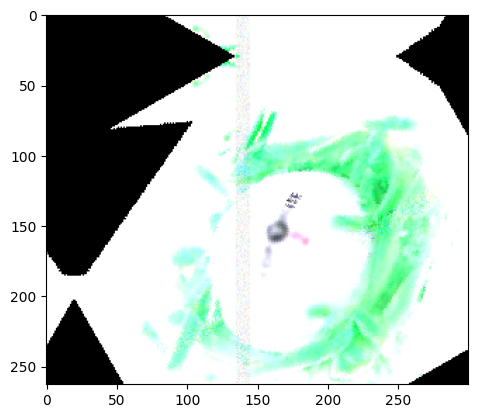

In [37]:
plt.imshow(misclassified_images[2])

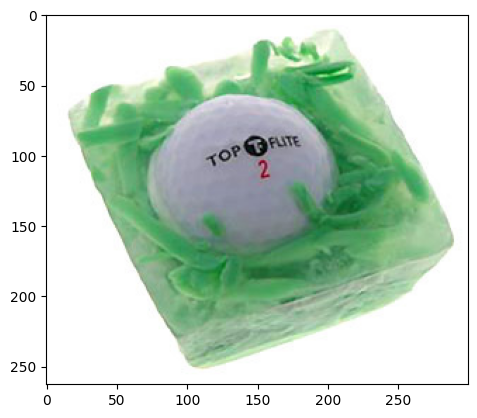

In [38]:
plt.imshow(misclassified_true_images[2])

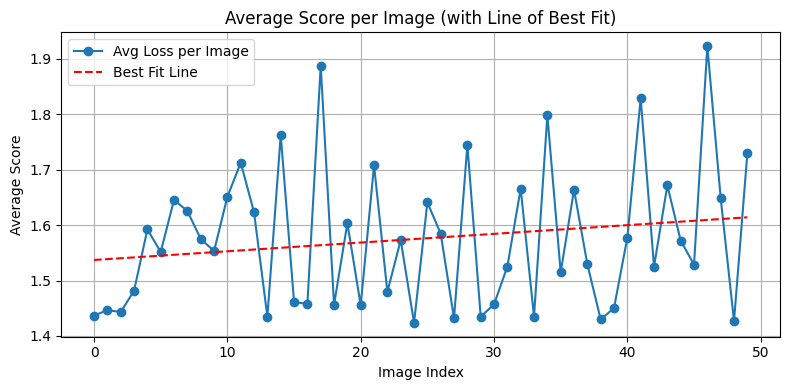

In [39]:
import matplotlib.pyplot as plt
import numpy as np

cur_loss_floats = [loss.item() for loss in cur_loss]

avg_loss_per_image = [
    sum(cur_loss_floats[i:i+3]) / 3 for i in range(0, len(cur_loss_floats), 3)
]

x = list(range(len(avg_loss_per_image)))
fit = np.polyfit(x, avg_loss_per_image, deg=1)
fit_line = np.poly1d(fit)

plt.figure(figsize=(8, 4))
plt.plot(x, avg_loss_per_image, marker='o', label="Avg Loss per Image")
plt.plot(x, fit_line(x), linestyle='--', color='red', label="Best Fit Line")
plt.xlabel("Image Index")
plt.ylabel("Average Score")
plt.title("Average Score per Image (with Line of Best Fit)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
first_loss = 0
second_loss = 0
third_loss = 0
for i in range(len(cur_loss)):
  if i % 3 == 0:
    first_loss += cur_loss[i]/(len(cur_loss)/3)
  elif i % 3 == 1:
    second_loss += cur_loss[i]/(len(cur_loss)/3)
  else:
    third_loss += cur_loss[i]/(len(cur_loss)/3)

In [41]:
total = 0
total2 = 0

for i in range(len(misclassified_images)):
  distance = image_distance(misclassified_true_images[i], misclassified_images[i], clip_model, clip_preprocess)
  total += distance
  #print(distance)
  distance2  = image_distance2(np.array(misclassified_true_images[i]), np.array(misclassified_images[i]))
  total2 += distance2

avg = total / len(misclassified_images)
print(len(misclassified_images))
print(f"Average distance between misclassified images: {avg}")
avg2 = total2 / len(misclassified_images)
print(f"Average distance between misclassified images: {avg2}")

33
Average distance between misclassified images: 0.19913367069128787
Average distance between misclassified images: 74929.56637318232
